# Problem 5: Getting Started with Pytorch.

In [1]:
from pathlib import Path
import requests
import torch
from torch import optim
from torch import nn
import pickle
import gzip
from matplotlib import pyplot
import numpy as np
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:


DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


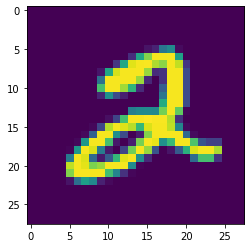

In [4]:
pyplot.imshow(x_train[5].reshape((28, 28)))
print(x_train.shape)
print(x_train)

In [5]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [6]:
print(torch.cuda.is_available())

True


In [7]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [41]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, train_loss, valid_loss, test_loss):
    
    for epoch in range(epochs):
        model.train()
        # Traing set, so catch train loss here
        loss = 0
        num = []
        for xb, yb in train_dl:
            lossX, numY = loss_batch(model, loss_func, xb, yb, opt)
            loss += (lossX * numY)
            num.append(numY) 

        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        valid_loss.append(val_loss)

        train_loss_curr =  loss / np.sum(num)
        train_loss.append(train_loss_curr)

        test_loss.append( np.sum(losses)/len(valid_dl)) # i think test loss is same as val loss, just because in this circumstance we use cross entropy for both

        print(epoch, val_loss)


    train = pyplot.plot(training_loss, label="train_loss")
    test = pyplot.plot(test_loss, label="test_loss")
    valid = pyplot.plot(valid_loss, label="valid")
    pyplot.legend()
    pyplot.show()
    return train, test, valid

In [9]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [10]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True), #shuffle data here, pull validation from same set
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [11]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [12]:

lr = 0.1  # learning rate
epochs = 2  # how many epochs to train for
loss_func = F.cross_entropy
bs = 32

from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)


valid_ds = TensorDataset(x_valid, y_valid)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [14]:

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

0 0.2412823960095644
1 0.13641826488375663
2 0.107312846904248
3 0.10517118532694876
4 0.0951405642259866
5 0.0878076923865825
6 0.08545208250060678
7 0.08230278699994087
8 0.07718006168305874
9 0.081043698297441
10 0.07392964620776475
11 0.07041237020120025
12 0.07164099177410826
13 0.07651227970849722
14 0.07607596914023161
15 0.06947915734816343
16 0.07016450091740116
17 0.06982422990498599
18 0.07141179294618778
19 0.07887982656797395
20 0.07406292182151228
21 0.07767533382368275
22 0.06893709683921188
23 0.07808259037614335
24 0.07487407840057277


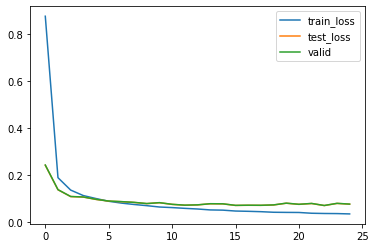

In [21]:

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model.to(dev)
opt = optim.SGD(model.parameters(), lr=.01, momentum=0.9)
training_loss = []
valid_loss = []
test_loss = []
fit(25, model, loss_func, opt, train_dl, valid_dl, training_loss,valid_loss, test_loss)

This was the best CNN we came up with. Although we stuck with the original architecture, we were able to manipulate the epochs, lr, bs, and momentum. Our CNN now performs better and produced a loss of around .07, which we believe is a good standard for accuracy. 

In [22]:

class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

0 0.2871080316543579
1 0.17870387071967125
2 0.2130470193207264
3 0.15381698573827743
4 0.13421123624742032
5 0.15509101531505584
6 0.1271285461679101
7 0.14624412668943404
8 0.11873453448414803
9 0.11029631900414824
10 0.11632790647745132
11 0.11778653787225485
12 0.11528293458670377
13 0.11910039099492133
14 0.12820704971980304
15 0.11640137254074216
16 0.11656218891665339
17 0.12573560044951737
18 0.11409724521301687
19 0.1079918973505497


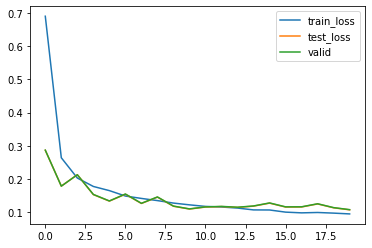

In [23]:
model = Mnist_CNN()
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
training_loss = []
valid_loss = []
test_loss = []
fit(20, model, loss_func, opt, train_dl, valid_dl, training_loss, valid_loss, test_loss)

# Problem 6: CNNs for CIFAR-10

In [24]:
#do this rarely, it takes a while to run


data = fetch_openml(data_id=40926)

In [25]:


sample_img_arr = data["data"].reshape(len(data["data"]), 3, 32, 32).transpose(0, 2, 3, 1).astype("int")
# fig1 = plt.imshow(sample_img_arr[13], interpolation='nearest')
# plt.show()
# fig2 = plt.imshow(sample_img_arr[26], interpolation='nearest')
# plt.show()
# fig3 = plt.imshow(sample_img_arr[33], interpolation='nearest')
# plt.show()

In [27]:

X_train, X_test, y_train, y_test = train_test_split(sample_img_arr, data["target"], train_size=.9, test_size=0.1)

X_train = torch.from_numpy(X_train.astype("float32"))
X_test = torch.from_numpy(X_test.astype("float32"))

y_train = torch.from_numpy(y_train.astype("long"))
y_test = torch.from_numpy(y_test.astype("long"))

print(X_train.dtype, y_train.dtype)

torch.float32 torch.int64


In [30]:
def preprocessCifar(x, y):
    return x.view(-1, 3, 32, 32).to(dev, dtype=torch.float), y.to(dev)

In [52]:
train_ds = TensorDataset(X_train.float(), y_train)

valid_ds = TensorDataset(X_train.float(), y_train)

test_ds = TensorDataset(X_test.float(), y_test)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=True)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocessCifar)
valid_dl = WrappedDataLoader(valid_dl, preprocessCifar)
test_dl = WrappedDataLoader(test_dl, preprocessCifar)

In [32]:

class CifarCNN(nn.Module):
  def __init__(self):
        super(CifarCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,   64,  3)
        self.conv2 = nn.Conv2d(64,  128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

0 1.957076313442654
1 1.874182591120402
2 1.9123575746748183
3 1.7798277458614773
4 1.6255459713406033
5 1.5997917035420737
6 1.5384667587280274
7 1.516569866604275
8 1.4406929391225178
9 1.4230129299163818
10 1.4230352440940008
11 1.3480903902053833
12 1.2150428675545586
13 1.180997159322103
14 1.1737686055501302


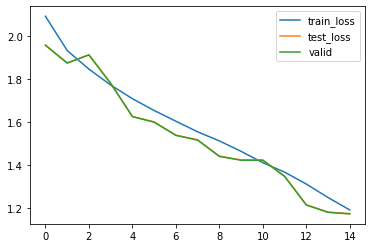

In [33]:
model = CifarCNN()
model.to(dev)
opt = optim.SGD(model.parameters(), lr=.001, momentum=0.5)
training_loss = []
valid_loss = []
test_loss = []
fit(15, model, loss_func, opt, train_dl, valid_dl, training_loss, valid_loss, test_loss)

In [49]:
from torch import optim
class BasicCifar(nn.Module):
    def __init__(self):
        super(BasicCifar, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 *4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.flatten(x)
        # x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

torch.float32
0 1.9603485543992785
1 1.9210828138987224
2 1.6736652352015178
3 1.6545320267147487
4 1.5730983254114788
5 1.4742441154056125
6 1.459049631860521
7 1.3321267807218764
8 1.1976280079947577
9 1.117708264350891
10 1.1812684970431857
11 0.9391675417158338
12 0.724771422651079
13 0.6584782880147299
14 0.44282777802149453
15 0.46403153053919477
16 0.42273680141237047
17 0.3680775365498331
18 0.31236396426624724
19 0.1926630271408293
20 0.23083197153939142
21 0.1288032168812222
22 0.20604716143343182
23 0.25589570426940916
24 0.19787835733758077


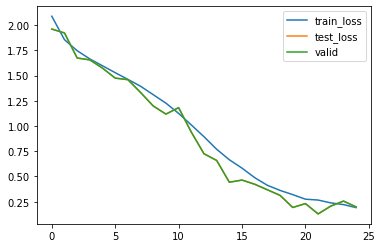

([<matplotlib.lines.Line2D at 0x7f987a2c8898>],
 [<matplotlib.lines.Line2D at 0x7f987a2c8358>])

In [50]:
print(X_train.dtype)
model = BasicCifar()
model.to(dev)
opt = optim.SGD(model.parameters(), lr=.01, momentum=0.5)
training_loss = []
valid_loss = []
test_loss = []
fit(25, model, loss_func, opt, train_dl, valid_dl, training_loss, valid_loss, test_loss)

In [ ]:
# model = nn.Sequential(
#     nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2),
#     nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv2d(128, 10, kernel_size=3, stride=2, padding=1),
#     nn.ReLU()
# )
# model.to(dev)
# opt = optim.SGD(model.parameters(), lr=.01, momentum=0.9)

# fit(20, model, loss_func, opt, train_dl, valid_dl)

Everything below here is for tracking loss

In [56]:
num_epochs = 15
learning_rate_constant = .001
learning_rate_vals = [.0001, .0005, .001, .0025, .005, .0075, .01]
lr_varied_training_loss = []
lr_varied_valid_loss = []
momentum_constant = 0.5
momentum_vals = [0.05, 0.1, 0.25, 0.5, 0.75]
momentum_varied_training_loss = []
momentum_varied_valid_loss = []

def get_model_loss(epochs, lr, momentum):
  model = CifarCNN()
  model.to(dev)
  opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  training_loss = []
  valid_loss = []
  test_loss = []
  fit(epochs, model, loss_func, opt, train_dl, valid_dl, training_loss, valid_loss, test_loss)
  return training_loss, valid_loss, np.mean(training_loss), np.mean(valid_loss)

lr: 0.0001
0 2.0735839472876654
1 2.001070857365926
2 1.9474897342258028
3 1.9043557563357882
4 1.9036643011305068
5 1.8539927715725368
6 1.835955781088935
7 1.823535441716512
8 1.8257608712514242
9 1.7912990481058757
10 1.756926117155287
11 1.7534302109612359
12 1.7565661144256592
13 1.7580742507510716
14 1.6966701867845324


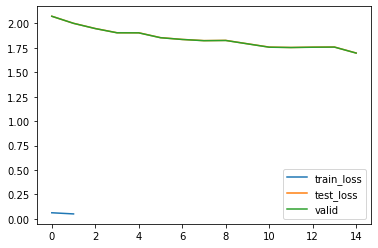


lr: 0.0005
0 1.9766736852857802
1 1.9408452932569715
2 2.003767140070597
3 1.7722942047119141
4 1.7100560338762072
5 1.6649335396024916
6 1.7087176204257541
7 1.6215288266075982
8 1.6835647077560425
9 1.5639881392584907
10 1.5171316244337294
11 1.523781435754564
12 1.4930701395670574
13 1.4107634700139364
14 1.439498957739936


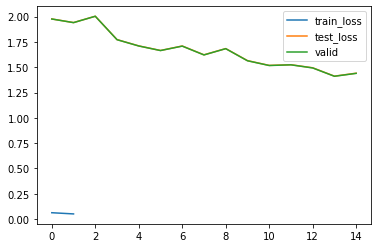


lr: 0.001
0 2.019711216184828
1 1.8180549026065402
2 1.8449385191599528
3 1.8433591259850397
4 1.6636213207244872
5 1.6013101682662965
6 1.5463650639851887
7 1.472373819563124
8 1.4604419530232748
9 1.4031909980773927
10 1.4402234930462308
11 1.393166926489936
12 1.2462030061086018
13 1.1099563133451673
14 1.218441194958157


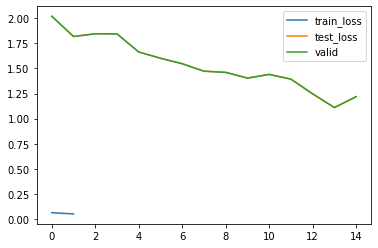


lr: 0.0025
0 1.9958918329874675
1 1.800633541531033
2 1.7729131272633871
3 1.6786747342215644
4 1.5867880971696642
5 1.4305194074842664
6 1.3625715607537163
7 1.2327640626695422
8 1.1287406396865844
9 1.152455712106493
10 1.1049463420444066
11 0.9773277246687148
12 0.8082628648546007
13 0.6748641089863248
14 0.613042334874471


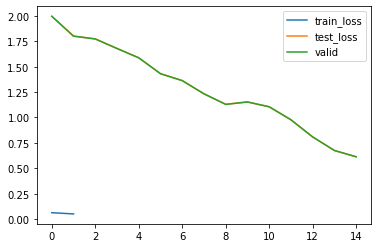


lr: 0.005
0 1.949389966752794
1 1.9209198332892523
2 1.704492365307278
3 1.6313255242241753
4 1.6881896154615614
5 1.4215541956159803
6 1.4145240887535944
7 1.5605965772204928
8 1.2151784817377727
9 1.109621308432685
10 1.071421132935418
11 0.9677134709888034
12 0.8422990829679701
13 0.790040099143982
14 0.6727707040574815


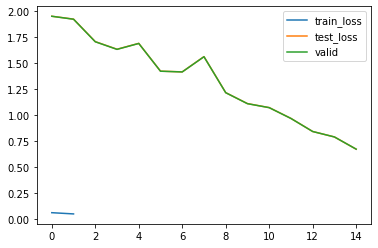


lr: 0.0075
0 1.9305770240359836
1 1.894381745868259
2 1.7288455912272136
3 1.6377841267055935
4 1.5389784411324394
5 1.5449985530641344
6 1.4221013639238145
7 1.42871771007114
8 1.3102307081222535
9 1.22760245068868
10 1.1144005175696479
11 1.102901972134908
12 0.8999684664408366
13 1.082852741877238
14 0.9116401304668851


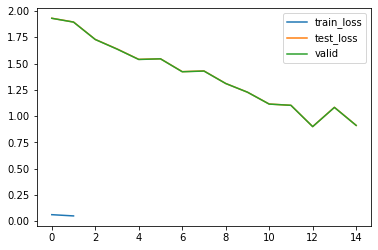


lr: 0.01
0 2.1310553824106853
1 1.979739427778456
2 2.0042947936587865
3 1.7203850498199462
4 1.640833166440328
5 1.5979982255299887
6 1.5425572970708212
7 1.3556080937915378
8 1.4372440039316814
9 1.2886168138715957
10 1.2958976804945204
11 1.2387286969290838
12 1.1063200012842813
13 0.9953360216352675
14 0.9930159726672703


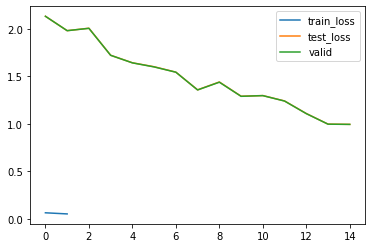

In [57]:
for lr_v in learning_rate_vals:
  print("lr: {}".format(lr_v))
  losses = get_model_loss(num_epochs, lr_v, momentum_constant)
  lr_varied_training_loss.append(losses[0])
  lr_varied_valid_loss.append(losses[1])
  print("") #ignore grpahs in this cell, they're unncesssary and invalid

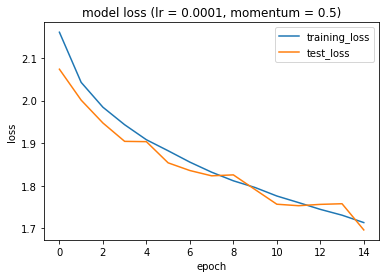

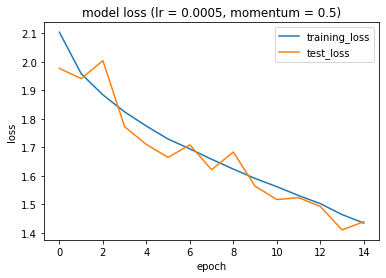

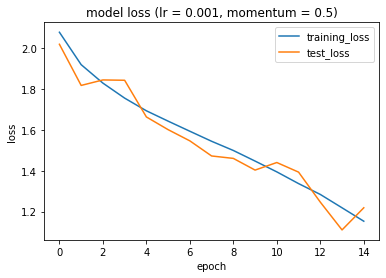

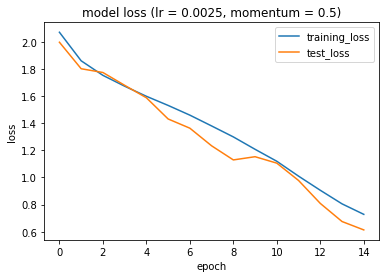

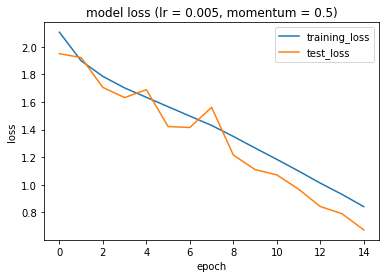

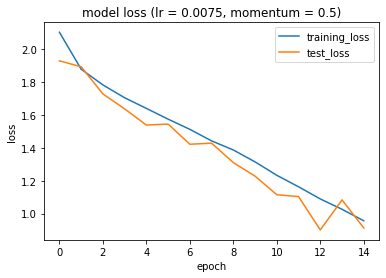

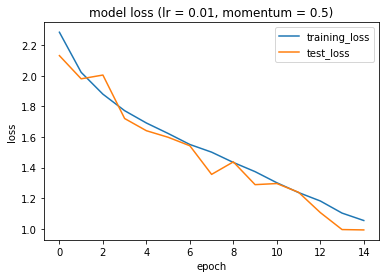

In [60]:
for i in range(len(learning_rate_vals)):
  pyplot.title('model loss (lr = {}, momentum = {})'.format(learning_rate_vals[i], momentum_constant))
  pyplot.xlabel('epoch')
  pyplot.ylabel('loss')
  pyplot.plot(lr_varied_training_loss[i], label="training_loss")
  pyplot.plot(lr_varied_valid_loss[i], label="test_loss")
  pyplot.legend()
  pyplot.show()

momentum: 0.05
0 2.064804436153836
1 1.9797472506629097
2 2.3266326842837866
3 1.842974961810642
4 2.100416485680474
5 1.6958728661007352
6 1.9416871637768216
7 1.7529826022254096
8 1.5990395669937134
9 1.636681720521715
10 1.5719264954460992
11 1.4923993292914497
12 1.4487312579684788
13 1.4078276105456882
14 1.372145712852478


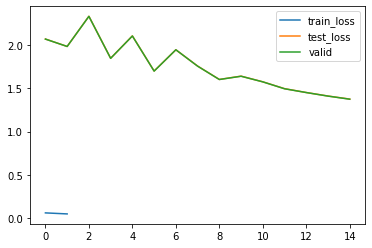


momentum: 0.1
0 2.010827514860365
1 2.004193149778578
2 1.8243012792799207
3 1.8005098045137193
4 1.7436554909812079
5 1.6503388246960111
6 1.7052209313710531
7 1.6057257391611734
8 1.6108793454700046
9 1.5239856074651081
10 1.5591760624779596
11 1.479046520974901
12 1.5420593704647487
13 1.4683119674258762
14 1.3880752118428548


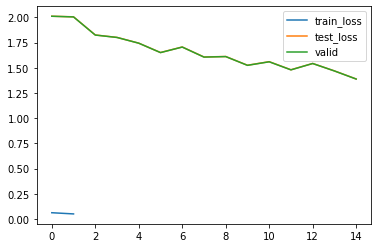


momentum: 0.25
0 2.066006723192003
1 1.9465549257066515
2 1.8878801737891304
3 1.7453198141521877
4 1.7458082554075454
5 1.7222548786799112
6 1.6364659006330702
7 1.7251274301740858
8 1.5939270387225681
9 1.5734565650092232
10 1.536264286465115
11 1.70033797677358
12 1.4909163839552138
13 1.3978019092347886
14 1.3620840060975816


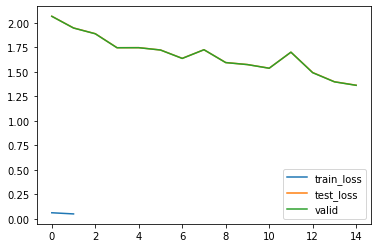


momentum: 0.5
0 2.0128693862491183
1 1.8432848076290556
2 1.7732895708084107
3 1.7690732156965467
4 1.7042710413402982
5 1.7114499638875325
6 1.5610854708353679
7 1.4885542309019302
8 1.493116111331516
9 1.3938177711698745
10 1.334369678709242
11 1.4343553433948093
12 1.2504449070824517
13 1.1510339730580648
14 1.0788055063883464


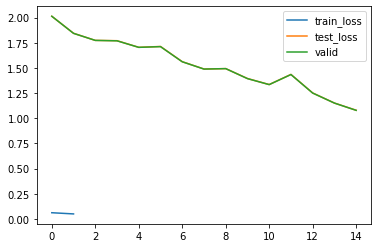


momentum: 0.75
0 1.9518763665093315
1 1.8180151036580403
2 1.8008211337195503
3 1.6338153760698106
4 1.602475493537055
5 1.5697057569291857
6 1.4558868859608969
7 1.3870448348787097
8 1.3844114061991373
9 1.2407762592103746
10 1.1561588462193806
11 1.0240413728290134
12 1.028909393204583
13 0.8838905295266045
14 0.8611753082275391


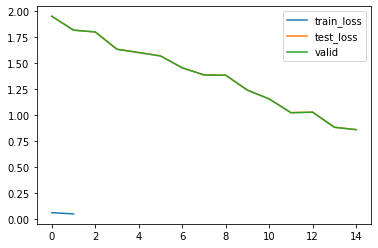

In [61]:
for m_v in momentum_vals:
  print("momentum: {}".format(m_v))
  losses = get_model_loss(num_epochs, learning_rate_constant, m_v)
  momentum_varied_training_loss.append(losses[0])
  momentum_varied_valid_loss.append(losses[1])
  print("")

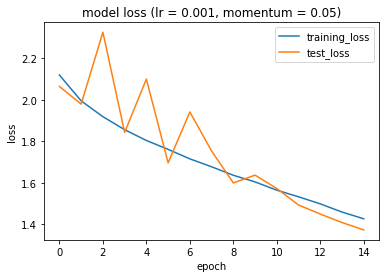

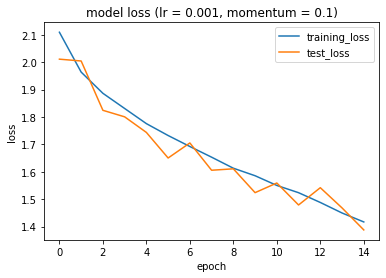

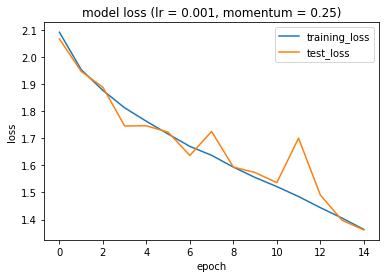

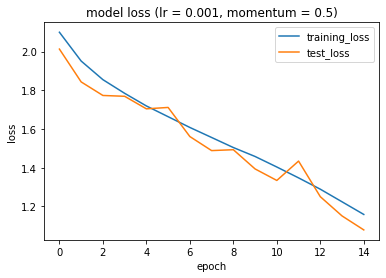

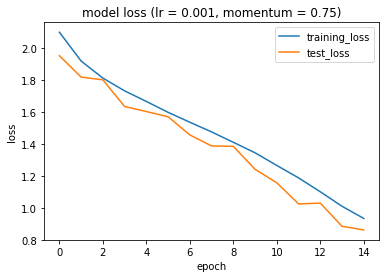

In [63]:
for i in range(len(momentum_vals)):
  pyplot.title('model loss (lr = {}, momentum = {})'.format(learning_rate_constant, momentum_vals[i]))
  pyplot.xlabel('epoch')
  pyplot.ylabel('loss')
  pyplot.plot(momentum_varied_training_loss[i], label="training_loss")
  pyplot.plot(momentum_varied_valid_loss[i], label="test_loss")
  pyplot.legend()
  pyplot.show()

A lower momentum seems to produce a slightly lower test loss, but the correlation seems somewhat weak.


## Is the depth of the CNN having a significant effect on performance? Describe the hyperparameters of the best model you could train.

The depth of the CNN has an effect on the performance. If there are too many layers, we may overfit, and similarily if there aren't enough layers, we may underfit. The best model would have the correct number of layers, the optimal learning rates and momenetums. It would also have Normalization layers and dropout layers. 